# Bias Detaction in `face-detction-0200`Model Using AIF 360

## AIF 360 ClassificationMetric Algorithm
Compares your model's predictions to the ground truth labels and computes a set of metrics that can be used to evaluate the fairness of your model. The metrics include:
* Disparate Impact (DI): Measures the ratio of the positive prediction rates for different groups. 
* Statistical Parity Difference (SPD): Measures the difference in positive prediction rates between groups. 
* Equal Opportunity Difference (EOD): Measures the difference in true positive rates between groups. 
* Average Odds Difference (AOD): Measures the difference in average odds between groups. 
* False Positive Rate Difference (FPRD): Measures the difference in false positive rates between groups. 
* Consistency: Measures the consistency of the model's predictions across different groups. 


In [ ]:
# pip install openvino
# pip install aif360


In [ ]:
import zipfile
from pathlib import Path
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import urllib.request
import cv2
import openvino as ov
from openvino.runtime import Core

from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric

from sklearn.model_selection import train_test_split


c:\Users\n_oha\anaconda3\envs\pymc_env\Lib\site-packages\openvino\runtime\__init__.py:10: DeprecationWarning: The `openvino.runtime` module is deprecated and will be removed in the 2026.0 release. Please replace `openvino.runtime` with `openvino`.
  warnings.warn(
c:\Users\n_oha\anaconda3\envs\pymc_env\Lib\site-packages\inFairness\utils\ndcg.py:37: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  vect_normalized_discounted_cumulative_gain = vmap(
c:\Users\n_oha\anaconda3\envs\pymc_env\Lib\site-packages\inFairness\utils\ndcg.py:48: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyT

## Prepare dataset

In [ ]:
with zipfile.ZipFile("fairface-img-margin025-trainval.zip", 'r') as zip_ref:
    zip_ref.extractall("./fairface/")


In [ ]:
# load combined dataset
df_train = pd.read_csv("fairface_label_train.csv")
df_train["split"] = "train"

df_val = pd.read_csv("fairface_label_val.csv")
df_val["split"] = "val"

df_base = pd.concat([df_train, df_val], ignore_index=True)
df = df_base.copy()


In [ ]:
IMG_DIR = "fairface"
df["image_path"] = df["file"].apply(lambda f: os.path.join(IMG_DIR, f))


In [ ]:
df = df[df["image_path"].apply(os.path.exists)].copy()


In [ ]:
df = df[df["image_path"].apply(os.path.exists)].copy()
print(f"Valid image rows: {len(df)}")


Valid image rows: 97698


In [ ]:
# Filter service_test == True

df = df[df['service_test'] == True]
df.columns


Index(['file', 'age', 'gender', 'race', 'service_test', 'split', 'image_path'], dtype='object')

In [ ]:
print(len(df["image_path"].values))


45414


In [ ]:
print(df['race'].unique())


['East Asian' 'Indian' 'White' 'Southeast Asian' 'Middle Eastern' 'Black'
 'Latino_Hispanic']


In [ ]:
print(df['age'].unique())


['50-59' '20-29' '30-39' '10-19' '60-69' '40-49' '3-9' '0-2'
 'more than 70']


In [ ]:
print("Unique race values:", df["race"].unique())
print("Unique gender values:", df["gender"].unique())
print("Unique age values:", df["age"].unique())


Unique race values: ['East Asian' 'Indian' 'White' 'Southeast Asian' 'Middle Eastern' 'Black'
 'Latino_Hispanic']
Unique gender values: ['Male' 'Female']
Unique age values: ['50-59' '20-29' '30-39' '10-19' '60-69' '40-49' '3-9' '0-2'
 'more than 70']


In [ ]:
# Encode the 'race' column as binary white or non-white.
race_map = {'East Asian': 1, 'Indian': 1, 'White': 0, 'Southeast Asian': 1,
            'Middle Eastern': 1, 'Black': 1, 'Latino_Hispanic': 1}
df = df[df['race'].isin(race_map)].copy()
df['race'] = df['race'].map(race_map)


# Encode the "gender" column
gender_map = {"Male": 0, "Female": 1}
df['gender'] = df['gender'].map(gender_map)

# Encode the "age" column using standard AIF360 metrics
# Binary age grouping: Young (<30) vs. Old (>=30)
age_map = {
    "0-2": 0, "3-9": 0, "10-19": 0, "20-29": 0, "30-39": 1,
    "40-49": 1, "50-59": 1, "60-69": 1, "70-79": 1, "more than 70": 1
}
df['age'] = df['age'].map(age_map)


# Drop rows with any NaN after mapping
df = df.dropna(subset=['race', 'gender', 'age'])

# Now safely cast to int
df['race'] = df['race'].astype(int)
df['gender'] = df['gender'].astype(int)
df['age'] = df['age'].astype(int)

df["ground_truth"] = 1
df["prediction"] = 1  # Placeholder for predictions

df.head(5)  # to see the first 5 rows of the dataframe
# df.columns.values.tolist()  # to see all the variables

df = df.copy()


In [ ]:
print("Race labels:", df['race'].unique())
print("Gender labels:", df['gender'].unique())
print("Age labels:", df['age'].unique())


Race labels: [1 0]
Gender labels: [0 1]
Age labels: [1 0]


In [ ]:
df.columns.values.tolist()


['file',
 'age',
 'gender',
 'race',
 'service_test',
 'split',
 'image_path',
 'ground_truth',
 'prediction']

## Setup OpenVINO Model and Detection Function



In [ ]:
# Load OpenVINO Inference Engine
core = Core()

# Load IR model (.xml and .bin files must be in the same directory)
model_path = "face-detection-0200.xml"
model = core.read_model(model_path)
compiled_model = core.compile_model(model, device_name="CPU")

# Get input and output layers
input_layer = compiled_model.input(0)
output_layer = compiled_model.output(0)


In [ ]:
def detect_face(image_path, threshold=0.95):
    try:
        # Load image
        image = cv2.imread(image_path)
        if image is None:
            print(f"[ERROR] Could not load image: {image_path}")
            return 0
        h, w = image.shape[:2]

        # Resize and preprocess (NCHW)
        input_tensor = cv2.resize(
            image, (input_layer.shape[3], input_layer.shape[2]))
        input_tensor = input_tensor.transpose((2, 0, 1))  # HWC to CHW
        input_tensor = np.expand_dims(input_tensor, axis=0).astype(np.float32)

        # Inference
        result = compiled_model([input_tensor])[output_layer]

        # Parse results
        for det in result[0][0]:
            confidence = det[2]
            if confidence > threshold:
                return 1  # Face detected
        return 0  # No detection passes threshold
    except Exception as e:
        # print(f"Error processing {image_path}: {e}")
        print(f"Detections for {image_path}: {[d[2] for d in result[0][0]]}")
        return 0


In [ ]:
# Pseudo-output for AIF360 format
df["prediction"] = [1 if detect_face(img) else 0 for img in df["image_path"]]


In [ ]:
df = df.copy()


In [ ]:
df.head(5)  # to see the first 5 rows of the dataframe


,file,age,gender,race,service_test,split,image_path,ground_truth,prediction
0,train/1.jpg,1,0,1,True,train,fairface\train/1.jpg,1,1
3,train/4.jpg,0,1,1,True,train,fairface\train/4.jpg,1,1
4,train/5.jpg,0,1,1,True,train,fairface\train/5.jpg,1,1
5,train/6.jpg,0,0,0,True,train,fairface\train/6.jpg,1,1
7,train/8.jpg,1,1,1,True,train,fairface\train/8.jpg,1,1


In [ ]:
# Re-split the dataset into train and val sets
df_train = df[df["split"] == "train"].copy()
df_val = df[df["split"] == "val"].copy()

print(f"Train: {len(df_train)}, Val: {len(df_val)}")


Train: 40252, Val: 5162


In [ ]:
# Split the dataset into train, validation, and test sets

# Split into train+val and test (20% test)
df_temp, df_test = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df["race"])

# Further split train+val into train and val (e.g., 75% train, 25% val)
df_train, df_val = train_test_split(
    df_temp, test_size=0.25, random_state=42, stratify=df_temp["race"])

# Confirm splits
print(f"Train: {len(df_train)}, Val: {len(df_val)}, Test: {len(df_test)}")


Train: 27248, Val: 9083, Test: 9083


# Apply AIF 360 Bias Detection

## Metric Interpretation

| **Metric**                    | **Ideal** | **Biased If...**                             |
| ----------------------------- | --------- | -------------------------------------------- |
| Disparate Impact              | ≈ 1.0     | < 0.8 or > 1.25 → favors one group           |
| Statistical Parity Difference | ≈ 0.0     | Large positive/negative → disparity in rates |
| Equal Opportunity Difference  | ≈ 0.0     | True positive rate differs across groups     |
| Average Odds Difference       | ≈ 0.0     | Combines TPR and FPR differences             |


## Bias Evaluation by Race

In [ ]:
# y_true = ground_truth (all 1s in this case)
# y_pred = prediction (from OpenVINO model)
# protected_attr = race (0 = White, 1 = Non-White)


aif_race = BinaryLabelDataset(
    df=df_val[["prediction", "ground_truth", "race"]],
    label_names=["ground_truth"],
    protected_attribute_names=["race"]
)

# Copy and assign model predictions as labels
race_pred = aif_race.copy()
race_pred.labels = df_val["prediction"].values.reshape(-1, 1)


In [ ]:
# Define groups
privileged_groups = [{'race': 0}]      # e.g., White
unprivileged_groups = [{'race': 1}]    # e.g., Non-White

# Compute bias metrics
metric = ClassificationMetric(
    aif_race, race_pred,
    privileged_groups=privileged_groups,
    unprivileged_groups=unprivileged_groups
)

# Print key fairness metrics
print("Disparate Impact:", metric.disparate_impact())
print("Statistical Parity Difference:", metric.statistical_parity_difference())
print("Equal Opportunity Difference:", metric.equal_opportunity_difference())
print("Average Odds Difference:", metric.average_odds_difference())


Disparate Impact: 1.018367381537679
Statistical Parity Difference: 0.01657578594990239
Equal Opportunity Difference: 0.01657578594990239
Average Odds Difference: nan


c:\Users\n_oha\anaconda3\envs\pymc_env\Lib\site-packages\aif360\metrics\classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
c:\Users\n_oha\anaconda3\envs\pymc_env\Lib\site-packages\aif360\metrics\classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


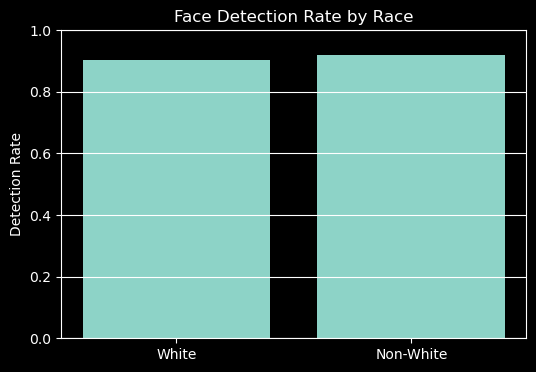

In [ ]:
# Calculate detection rate per group
group_rates = df_val.groupby("race")["prediction"].mean()
group_counts = df_val["race"].value_counts()

# Convert to display names
group_names = {0: "White", 1: "Non-White"}

plt.figure(figsize=(6, 4))
plt.bar([group_names[k] for k in group_rates.index], group_rates.values)
plt.title("Face Detection Rate by Race")
plt.ylabel("Detection Rate")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()


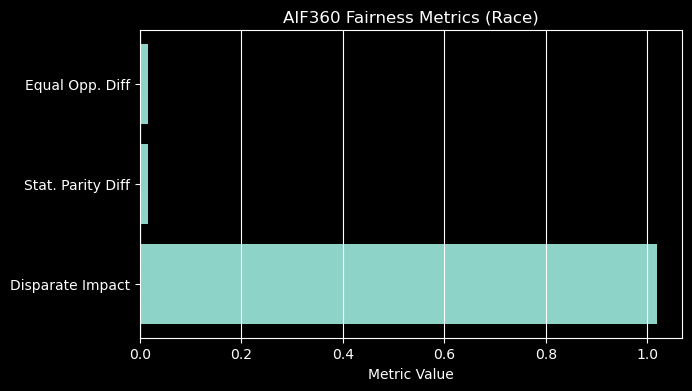

In [ ]:
metrics = {
    "Disparate Impact": metric.disparate_impact(),
    "Stat. Parity Diff": metric.statistical_parity_difference(),
    "Equal Opp. Diff": metric.equal_opportunity_difference(),
    "Avg. Odds Diff": metric.average_odds_difference()
}

plt.figure(figsize=(7, 4))
plt.barh(list(metrics.keys()), list(metrics.values()))
plt.axvline(0, color='gray', linestyle='--')
plt.title("AIF360 Fairness Metrics (Race)")
plt.xlabel("Metric Value")
plt.grid(axis='x')
plt.show()


## Bias Evaluation by Gender

In [ ]:
# Gender metrics

aif_gender = BinaryLabelDataset(
    df=df_val[["prediction", "ground_truth", "gender"]],
    label_names=["ground_truth"],
    protected_attribute_names=["gender"]
)

gender_pred = aif_gender.copy()
gender_pred.labels = df_val["prediction"].values.reshape(-1, 1)


In [ ]:
# Define groups
privileged = [{'gender': 0}]		# Male
unprivileged = [{'gender': 1}]		# Female


metric_gender = ClassificationMetric(
    aif_gender,
    gender_pred,
    privileged_groups=privileged,
    unprivileged_groups=unprivileged
)

# Print metrics
print("Fairness metrics by gender:")
print("Disparate Impact:", metric_gender.disparate_impact())
print("Statistical Parity Difference:",
      metric_gender.statistical_parity_difference())
print("Equal Opportunity Difference:",
      metric_gender.equal_opportunity_difference())
print("Average Odds Difference:", metric_gender.average_odds_difference())


Fairness metrics by gender:
Disparate Impact: 1.0263030585963757
Statistical Parity Difference: 0.023799923507899834
Equal Opportunity Difference: 0.023799923507899834
Average Odds Difference: nan


c:\Users\n_oha\anaconda3\envs\pymc_env\Lib\site-packages\aif360\metrics\classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
c:\Users\n_oha\anaconda3\envs\pymc_env\Lib\site-packages\aif360\metrics\classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


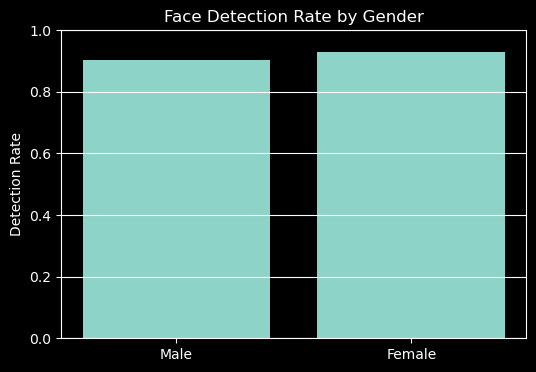

In [ ]:
# Calculate detection rate per group
group_rates = df_val.groupby("gender")["prediction"].mean()
group_counts = df_val["gender"].value_counts()

# Convert to display names
group_names = {0: "Male", 1: "Female"}

plt.figure(figsize=(6, 4))
plt.bar([group_names[k] for k in group_rates.index], group_rates.values)
plt.title("Face Detection Rate by Gender")
plt.ylabel("Detection Rate")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()


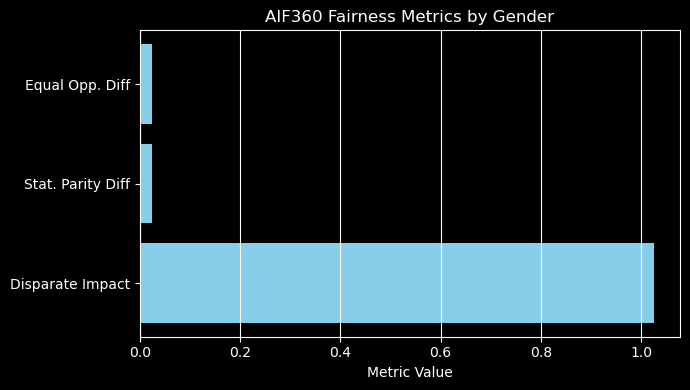

In [ ]:
# Collect metric values into a dictionary
gender_metrics = {
    "Disparate Impact": metric_gender.disparate_impact(),
    "Stat. Parity Diff": metric_gender.statistical_parity_difference(),
    "Equal Opp. Diff": metric_gender.equal_opportunity_difference(),
    "Avg. Odds Diff": metric_gender.average_odds_difference()
}

# Plot as horizontal bar chart
plt.figure(figsize=(7, 4))
plt.barh(list(gender_metrics.keys()), list(
    gender_metrics.values()), color='skyblue')
plt.axvline(0, color='gray', linestyle='--')
plt.title("AIF360 Fairness Metrics by Gender")
plt.xlabel("Metric Value")
plt.grid(axis='x')
plt.tight_layout()
plt.show()


## Bias Evaluation by Age

In [ ]:
# Age metrics

aif_age = BinaryLabelDataset(
    df=df_val[["prediction", "ground_truth", "age"]],
    label_names=["ground_truth"],
    protected_attribute_names=["age"]
)

# Copy and assign model predictions as labels
age_pred = aif_age.copy()
age_pred.labels = df_val["prediction"].values.reshape(-1, 1)


In [ ]:
# Define groups
privileged_groups = [{'age': 0}]      # Young
unprivileged_groups = [{'age': 1}]      # Old

# Compute bias metrics
metric_age = ClassificationMetric(
    aif_age,
    age_pred,
    privileged_groups=privileged_groups,
    unprivileged_groups=unprivileged_groups
)

# Print key fairness metrics
print("Disparate Impact:", metric_age.disparate_impact())
print("Statistical Parity Difference:",
      metric_age.statistical_parity_difference())
print("Equal Opportunity Difference:",
      metric_age.equal_opportunity_difference())
print("Average Odds Difference:", metric_age.average_odds_difference())


Disparate Impact: 0.9742389746184332
Statistical Parity Difference: -0.023861594938686226
Equal Opportunity Difference: -0.023861594938686226
Average Odds Difference: nan


c:\Users\n_oha\anaconda3\envs\pymc_env\Lib\site-packages\aif360\metrics\classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
c:\Users\n_oha\anaconda3\envs\pymc_env\Lib\site-packages\aif360\metrics\classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


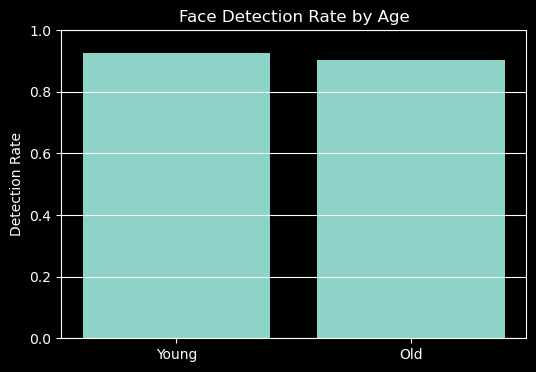

In [ ]:
# Calculate detection rate per group
group_rates = df_val.groupby("age")["prediction"].mean()
group_counts = df_val["age"].value_counts()

# Convert to display names
group_names = {0: "Young", 1: "Old"}

plt.figure(figsize=(6, 4))
plt.bar([group_names[k] for k in group_rates.index], group_rates.values)
plt.title("Face Detection Rate by Age")
plt.ylabel("Detection Rate")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()


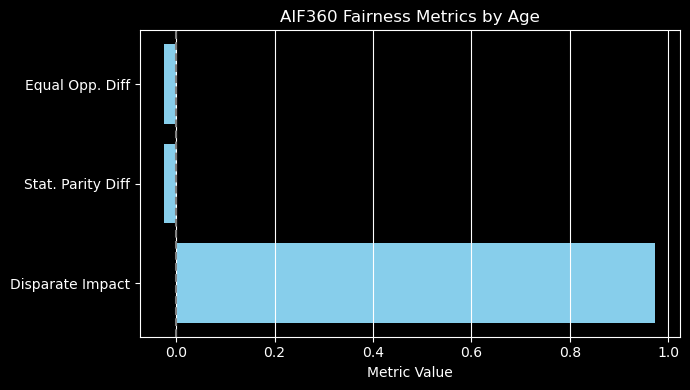

In [ ]:
# Collect metric values into a dictionary
age_metrics = {
    "Disparate Impact": metric_age.disparate_impact(),
    "Stat. Parity Diff": metric_age.statistical_parity_difference(),
    "Equal Opp. Diff": metric_age.equal_opportunity_difference(),
    "Avg. Odds Diff": metric_age.average_odds_difference()
}

# Plot as horizontal bar chart
plt.figure(figsize=(7, 4))
plt.barh(list(age_metrics.keys()), list(
    age_metrics.values()), color='skyblue')
plt.axvline(0, color='gray', linestyle='--')
plt.title("AIF360 Fairness Metrics by Age")
plt.xlabel("Metric Value")
plt.grid(axis='x')
plt.tight_layout()
plt.show()
